cuda:0
epoch: 0, Train Loss: 6.324362, Eval Loss: 3.805430
epoch: 1, Train Loss: 2.756091, Eval Loss: 3.200463
epoch: 2, Train Loss: 2.299514, Eval Loss: 2.791088
epoch: 3, Train Loss: 2.208479, Eval Loss: 2.813734
epoch: 4, Train Loss: 2.186042, Eval Loss: 2.799404
epoch: 5, Train Loss: 2.154257, Eval Loss: 2.709434
epoch: 6, Train Loss: 2.115992, Eval Loss: 2.601264
epoch: 7, Train Loss: 2.026657, Eval Loss: 2.542532
epoch: 8, Train Loss: 1.856016, Eval Loss: 2.117023
epoch: 9, Train Loss: 1.349750, Eval Loss: 1.298371
epoch: 10, Train Loss: 0.987298, Eval Loss: 0.986991
epoch: 11, Train Loss: 0.786253, Eval Loss: 0.823243
epoch: 12, Train Loss: 0.657331, Eval Loss: 0.637652
epoch: 13, Train Loss: 0.565821, Eval Loss: 0.685244
epoch: 14, Train Loss: 0.546907, Eval Loss: 0.578360
epoch: 15, Train Loss: 0.523390, Eval Loss: 0.570186
epoch: 16, Train Loss: 0.513560, Eval Loss: 0.507243
epoch: 17, Train Loss: 0.479408, Eval Loss: 0.512872
epoch: 18, Train Loss: 0.449272, Eval Loss: 0.513

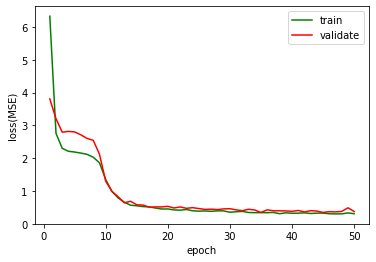

tensor(0.0170, device='cuda:0', grad_fn=<DivBackward0>)


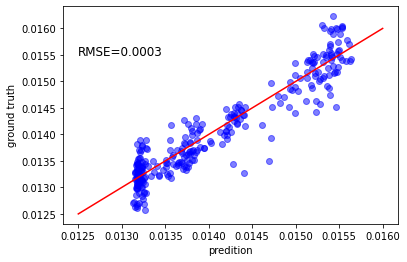

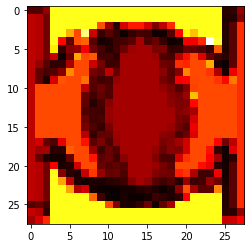

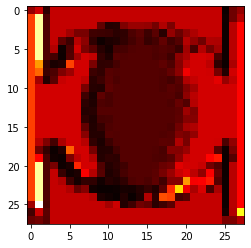

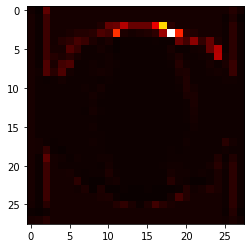

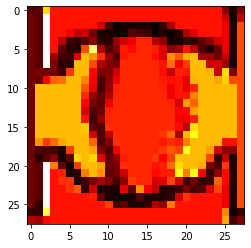

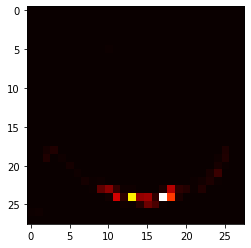

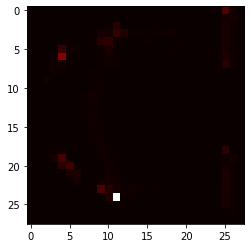

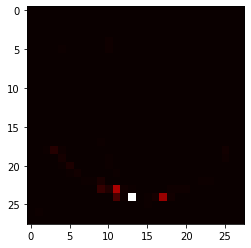

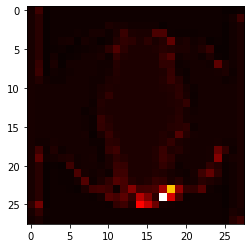

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.nn.init as init
import nibabel as nib
import os
import time
from scipy import ndimage
from nibabel.viewers import OrthoSlicer3D
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
from einops.layers.torch import Rearrange
from sklearn.metrics import mean_squared_error

# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
# torch.manual_seed(0)
BATCH_SIZE_TRAIN = 64


def _weights_init(m):  # 權重初始化
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d):
        init.kaiming_normal_(m.weight)


class LayerNormalize(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class MLP_Block(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.nn1 = nn.Linear(dim, hidden_dim)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.normal_(self.nn1.bias, std=1e-6)
        self.af1 = nn.GELU()
        self.do1 = nn.Dropout(dropout)
        self.nn2 = nn.Linear(hidden_dim, dim)
        torch.nn.init.xavier_uniform_(self.nn2.weight)
        torch.nn.init.normal_(self.nn2.bias, std=1e-6)
        self.do2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.nn1(x)
        x = self.af1(x)
        x = self.do1(x)
        x = self.nn2(x)
        x = self.do2(x)

        return x


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5  # 1/sqrt(dim)

        self.to_qkv = nn.Linear(dim, dim * 3, bias=True)  # Wq,Wk,Wv for each vector, thats why *3
        torch.nn.init.xavier_uniform_(self.to_qkv.weight)
        torch.nn.init.zeros_(self.to_qkv.bias)

        self.nn1 = nn.Linear(dim, dim)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.zeros_(self.nn1.bias)
        self.do1 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)  # gets q = Q = Wq matmul x1, k = Wk mm x2, v = Wv mm x3
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)  # split into multi head attentions
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value=True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)  # follow the softmax,q,d,v equation in the paper

        out = torch.einsum('bhij,bhjd->bhid', attn, v)  # product of v times whatever inside softmax
        out = rearrange(out, 'b h n d -> b n (h d)')  # concat heads into one matrix, ready for next encoder block
        out = self.nn1(out)
        out = self.do1(out)
        return out


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(LayerNormalize(dim, Attention(dim, heads=heads, dropout=dropout))),
                Residual(LayerNormalize(dim, MLP_Block(dim, mlp_dim, dropout=dropout)))
            ]))

    def forward(self, x, mask=None):
        for attention, mlp in self.layers:
            x = attention(x, mask=mask)  # go to attention
            x = mlp(x)  # go to MLP_Block
        return x


class ViTNet(nn.Module):
    def __init__(self, num_classes=1, dim=16, num_tokens=8, mlp_dim=128, heads=8, depth=6, emb_dropout=0.2, dropout=0.2):
        super(ViTNet, self).__init__()
        self.in_planes = 16
        self.L = num_tokens
        self.cT = dim

#         self.to_patch_embedding = nn.Sequential(
#             Rearrange('b c (h p1) (w p2) (d p3)-> b (h w d) (p1 p2 p3 c)', p1=16, p2=16, p3=16),
#             nn.Linear(16**3, 64),
#         )

        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, bias=False)
        self.conv2 = nn.Conv3d(8, dim, kernel_size=3, stride=1, bias=False)
        self.bn1 = nn.BatchNorm3d(8)
        self.bn2 = nn.BatchNorm3d(dim)
        self.pool = nn.MaxPool3d(2)
        self.apply(_weights_init)  # 權重初始化

        # Tokenization
        self.token_wA = nn.Parameter(torch.empty(self.L, dim), requires_grad=True)  # Tokenization parameters
        torch.nn.init.xavier_uniform_(self.token_wA)
        self.token_wV = nn.Parameter(torch.empty(dim, self.cT), requires_grad=True)  # Tokenization parameters
        torch.nn.init.xavier_uniform_(self.token_wV)

        self.pos_embedding = nn.Parameter(torch.empty(1, (num_tokens + 1), dim))
        torch.nn.init.normal_(self.pos_embedding, std=.02)  # initialized based on the paper
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))  # initialized based on the paper
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)
        self.to_cls_token = nn.Identity()

        # output
        self.nn1 = nn.Linear(dim, num_classes)  # if finetuning, just use a linear layer without further hidden layers (paper)
        torch.nn.init.xavier_uniform_(self.nn1.weight)
        torch.nn.init.normal_(self.nn1.bias, std=1e-6)
        self.nn2 = nn.Linear(dim*num_tokens, dim)
        torch.nn.init.xavier_uniform_(self.nn2.weight)
        torch.nn.init.normal_(self.nn2.bias, std=1e-6)

    def forward(self, x, mask=None):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = rearrange(x, 'b c d h w -> b (d h w) c')
        # x = self.to_patch_embedding(x)

        # Tokenization
        wa = rearrange(self.token_wA, 'h w -> w h')  # Transpose
        A = torch.einsum('bij,jk->bik', x, wa)  # 矩陣乘法
        A = rearrange(A, 'b h w -> b w h')  # Transpose
        A = A.softmax(dim=-1)
        # VV = torch.einsum('bij,bjk->bik', x, self.token_wV)
        T = torch.einsum('bij,bjk->bik', A, x)  # the difference of  VT & ViT

#         cls_tokens = self.cls_token.expand(T.shape[0], -1, -1)
#         x = torch.cat((cls_tokens, T), dim=1)
#         x += self.pos_embedding
#         T = self.dropout(x)
        x = self.transformer(T, mask)  # main game
#         x = self.to_cls_token(x[:, 0])
        x = self.to_cls_token(x[:, :]).reshape(x.shape[0], -1)
        x = F.relu(self.nn2(x))
        x = self.nn1(x)
        return x


class CT_scan(Dataset):
    def __init__(self, train=True):
        self.train = train
        self.x_train, self.y_train = np.load('N38_initial_x_train.npy'), np.load('N38_initial_y_train.npy')
        self.x_val, self.y_val = np.load('N38_initial_x_val.npy'), np.load('N38_initial_y_val.npy')

    def __getitem__(self, index):
        if self.train:
            inputs, target = self.x_train[index, :, :, :, :], self.y_train[index]
        else:
            inputs, target = self.x_val[index, :, :, :, :], self.y_val[index]
        inputs = torch.from_numpy(inputs).type(torch.cuda.FloatTensor)
        target = torch.from_numpy(np.array(target)).type(torch.cuda.FloatTensor)
        return inputs, target

    def __len__(self):
        if self.train:
            return len(self.x_train)
        else:
            return len(self.x_val)


def main():
    train_data = CT_scan(train=True)
    test_data = CT_scan(train=False)
    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=0)
    test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE_TRAIN, shuffle=False, num_workers=0)
    t_start = time.time()
    model = ViTNet().cuda()
    criterion = torch.nn.MSELoss()
    lr = 1e-3
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.)
    epoch = 50
    tl = []
    vl = []
    for i in range(epoch):
        train_loss = 0.0
        val_loss = 0.0
        t, v = 0, 0
        model.train()
        for inputs, labels in train_loader:
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            optim.zero_grad()
            loss.backward()
            optim.step()
            train_loss += loss.item()
        for inputs, labels in test_loader:
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            val_loss += loss.item()
        print('epoch: {}, Train Loss: {:.6f}, Eval Loss: {:.6f}'.format(i, train_loss/8,
                                                                        val_loss/2))
        tl.append(train_loss / 8)
        vl.append(val_loss / 2)
    
    torch.save(model, 'CNN-Transformer.pth')
    del train_data, train_loader
    t_end = time.time()
    print((t_end-t_start)/60)
    
    plt.plot(np.linspace(1, epoch, epoch), tl, c='green', label='train')
    plt.plot(np.linspace(1, epoch, epoch), vl, c='red', label='validate')
    plt.xlabel('epoch')
    plt.ylabel('loss(MSE)')
    plt.legend()
    plt.show()
    plt.close()
    
    model.eval()
    deviation = 0.0
    mean, sigma = 0.01405307, np.sqrt(7.6813655e-07)
    y, l = np.array([]), np.array([])
    for inputs, labels in test_loader:
            y_pred = model(inputs)
            y_pred, labels = (y_pred*sigma)+mean, (labels*sigma)+mean
            y = np.append(y,y_pred.cpu().detach().numpy().reshape(-1, 1))
            l = np.append(l,labels.cpu().detach().numpy().reshape(-1, 1))
            plt.scatter(y_pred.cpu().detach().numpy(), labels.cpu().detach().numpy(), c='blue',alpha=0.5)
            deviation += torch.sum(torch.abs(y_pred-labels)/labels)
    print(deviation/len(test_data))
    plt.plot([0.0125, 0.016], [0.0125, 0.016], c='red')
    mse = mean_squared_error(y, l)
    plt.text(0.0125, 0.0155, 'RMSE='+str(round(np.sqrt(mse), 4)),fontsize=12)
    plt.xlabel('predition')
    plt.ylabel('ground truth')
    plt.show()
    plt.close()
    
    weight = weight_vis(model, test_data[0][0].reshape(1, 1, 60, 60, 60)).cpu().detach().numpy().reshape(1, 8, 28, 28, 28)
    for i in range(8):
        plt.imshow(weight[0, i, :, :, 14], cmap='hot', vmax=np.max(weight[0, i, :, :, 14]), vmin=np.min(weight[0, i, :, :, 14]))
        plt.show()
        plt.close()
    
    
    
def weight_vis(net, inputs):
    x = F.relu(net.bn1(net.conv1(inputs)))
    x = F.relu(net.bn2(net.conv2(x)))
    x = net.pool(x)
    x = rearrange(x, 'b c d h w -> b (d h w) c')
    wa = rearrange(net.token_wA, 'h w -> w h')  
    A = torch.einsum('bij,jk->bik', x, wa)
    A = rearrange(A, 'b h w -> b w h')  
    A = A.softmax(dim=-1)
    return A
    
        
if __name__ == '__main__':
    main()